In [1]:
import numpy as np 
from scipy.sparse import diags
from mpl_toolkits.mplot3d import Axes3D
from utils import *
import matplotlib.pyplot as plt


<h1>Requirements</h1>

<h2>Functions to compute the expected return of the "stick" action being in a certain state</h2>

In [2]:
def get_stick_WLD(p):
    
    win_fix_part = np.expand_dims(np.concatenate([np.linspace(10,0,11), np.linspace(1,5,5 )])/20,1)
    lose_fix_part , draw_fix_part = np.zeros((16,1)), np.zeros((16,1))
    WLD_fix_part = np.concatenate([win_fix_part, lose_fix_part, draw_fix_part], axis = 1)
    
    WLD_var_part = np.zeros((16,3))
    
    if p < 17:
        WLD_var_part[6:,1] = np.reshape(np.concatenate([np.linspace(1,5,5), [5 for i in range(5)]], axis = 0),-1)
    elif p == 17:
        WLD_var_part[6:,2] = np.ones((10,))
        WLD_var_part[6:,1] = np.reshape(np.concatenate([np.linspace(0,4,5), [4 for i in range(5)]], axis = 0),-1)
    elif p == 18:
        WLD_var_part[6:,0] = np.ones((10,))
        WLD_var_part[6:,1] = np.concatenate([[0,0] ,np.concatenate([np.linspace(1,3,3), [3 for i in range(5)]], axis = 0)],0)
        WLD_var_part[6:,2] = np.concatenate([[0] ,np.ones((9,))],0)
    elif p == 19:
        WLD_var_part[6:,0] = np.concatenate([[1],2*np.ones((9,))],axis = 0 )
        WLD_var_part[6:,1] = np.concatenate([np.zeros((3,)) ,np.concatenate([np.linspace(1,2,2), [2 for i in range(5)]], axis = 0)],0)
        WLD_var_part[6:,2] = np.concatenate([[0,0] ,np.ones((8,))],0)
    elif p == 20:
        WLD_var_part[6:,0] = np.concatenate([[1,2],3*np.ones((8,))],axis = 0 )
        WLD_var_part[6:,1] = np.concatenate([np.zeros((4,)) ,np.ones((6,))],0)
        WLD_var_part[6:,2] = np.concatenate([np.zeros(3,) ,np.ones((7,))],0)
    elif p == 21:
        WLD_var_part[6:,0] = np.concatenate([[1,2,3],4*np.ones((7,))],axis = 0 )
        WLD_var_part[6:,1] = np.zeros((10,))
        WLD_var_part[6:,2] = np.concatenate([np.zeros((4,)) ,np.ones((6,))],0)
  
    return WLD_fix_part + WLD_var_part/20

def get_expected_return_state(p, iterations):
    id_ = np.eye(3)
    C = np.concatenate([np.zeros((3,2)), np.ones((3,1))], axis =1)
    zeros_ = np.zeros((3,16))
    WLD = get_stick_WLD(p)
    diagonals = np.reshape([[1/20 * np.array([1 for i in range (j)]), 1/20 * np.array([1 for i in range (j)])] for j in reversed(range (6,16))],-1)
    diagonals_index = np.reshape([[-i,i]for i in range(1,11)],-1)
    A = diags(diagonals, diagonals_index).toarray()

    P_first_rows = np.concatenate([C , zeros_], axis =1)
    P_last_rows = np.concatenate([WLD, A], axis =1)

    P_tot = np.concatenate([P_first_rows, P_last_rows], axis = 0)

    #we now construct the reward vector
    reward = np.concatenate([[1,-1], np.zeros((17,))])
    
    #Let's do value iteration!!
    reward_stick = np.zeros((19,))
    old_reward_stick = None
    #norms = []
    for it in range(iterations):
        reward_stick = reward + np.dot(P_tot, reward_stick)

    return reward_stick

def truncate_reward_stick(p, iterations):
    return get_expected_return_state(p,iterations)[3:13]


<h2>Functions to compute the transition matrix of the "hit" action</h2>

In [3]:
def construct_P_hit():
    
    diagonals_hit = np.reshape([[1/20 * np.array([1 for i in range (j)]), 1/20 * np.array([1 for i in range (j)])] for j in reversed(range (11,21))],-1)
    diagonals_hit_index = np.reshape([[-i,i]for i in range(1,11)],-1)
    A_hit = diags(diagonals_hit, diagonals_hit_index).toarray()
    P_hit = np.zeros((10*21,10*21))
    for i in range(10):
        P_hit[i*21:(i+1)*21,i*21:(i+1)*21] = A_hit
    
    C = np.concatenate([np.zeros((3,2)), np.ones((3,1))], axis =1)
    zeros_ = np.zeros((3,210))
    
    lose_fix_part = np.concatenate([np.concatenate([np.linspace(10,0,11), np.linspace(1,10,10)],0)/20 for i in range(10)],0)
    win_fix_part, draw_fix_part = np.zeros((210,1)), np.zeros((210,1))
    WLD = np.concatenate([win_fix_part, np.expand_dims(lose_fix_part,1), draw_fix_part], 1)
    
    
    P_first_rows = np.concatenate([C , zeros_], axis =1)
    P_last_rows = np.concatenate([WLD, P_hit], axis =1)

    P_hit = np.concatenate([P_first_rows, P_last_rows], axis = 0)
    return P_hit




<h1>Value iteration</h1>

In [4]:
#Now let's consider the initial MDP where the player has 2 possible actions.

def get_requirements():
    #let's construct the transition matrix for the MDP where the dealer plays alone and the player's sum is constant.
    iterations = 200

    ##We first compute the reward and transition matrix associated with the "hit" action
    reward_hit = -1/20 * np.concatenate([np.concatenate([np.linspace(10,1,10),[0], np.linspace(1,10,10)],0) for i in range(10)], 0)
    reward_hit = np.concatenate([[1,-1,0],reward_hit],0)
    P_hit = construct_P_hit()



    ##Then the reward and transition matrix associated with the "stick" action.
    ##When the player sticks, he get to the draw state.
    reward_stick = np.array([truncate_reward_stick(p,iterations) for p in range(1,22)])
    reward_stick = np.reshape(np.transpose(reward_stick),-1)   
    reward_stick = np.concatenate([[1,-1,0], reward_stick], 0)
    P_stick = np.concatenate([np.zeros((213,2)), np.zeros((213,1)), np.zeros((213,210))], axis = 1)
    return reward_hit, P_hit, reward_stick, P_stick


In [5]:
##Value Iteration
def value_iteration(iterations):
    value_tot = np.zeros((3 + 10*21,))
    reward_hit, P_hit, reward_stick, P_stick = get_requirements()
    for it in range(iterations):
        value_tot  = np.maximum(reward_hit + np.dot(P_hit,value_tot), reward_stick + np.dot(P_stick, value_tot))
    value_without_WLD = value_tot[3:]
    value_without_WLD  = np.reshape(value_without_WLD, (10,21))
    return value_without_WLD

<h2>Plotting the value function</h2>


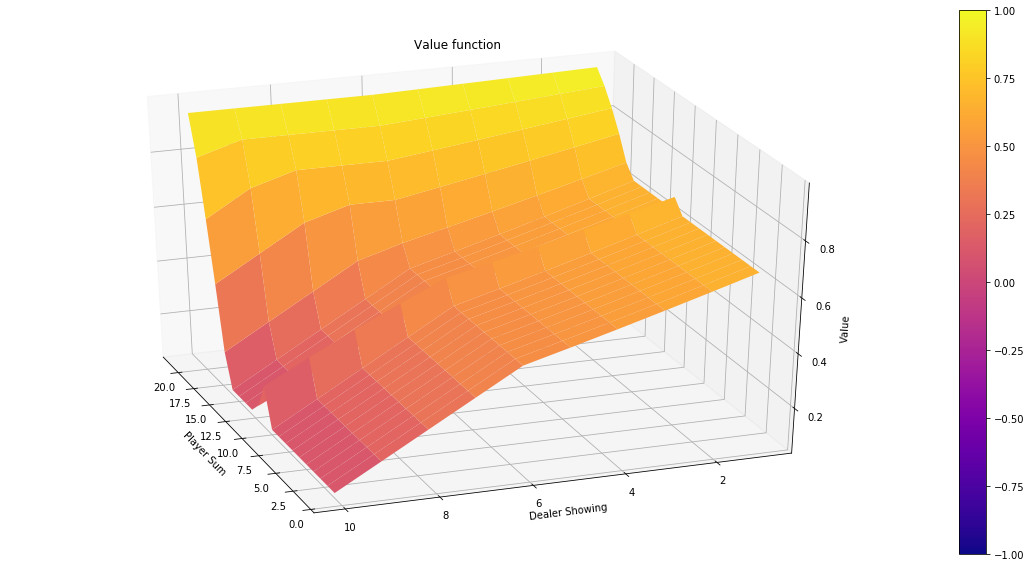

In [6]:
iterations = 1000
value_function = value_iteration(iterations)
plt.clf()
plot_value_function(value_function, plt.cm.plasma, degree = -200)

In [8]:
np.save("results/theoretical_value_function.npy", value_function)

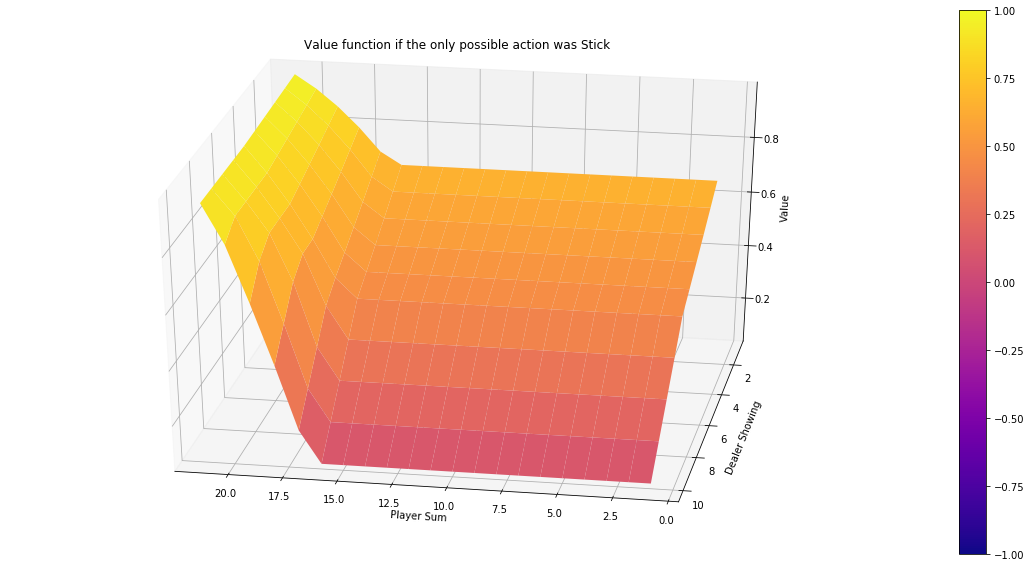

In [10]:
##Just by curiosity, let's plot the expected return of each state if the only possible return was "Stick"...
reward_stick = np.array([truncate_reward_stick(p,iterations) for p in range(1,22)])
np.save("results/stick_value_function.npy", reward_stick.transpose())
plt.clf()
plot_value_function(reward_stick.transpose(), cm = plt.cm.plasma, title = "Value function if the only possible action was Stick", degree=100)